The approach:

1. Prepare a cloud-free mosaic of WV3 that is closest to the lidar collection date. Ideally, it would be from 2018. But 2019 or 2020 are also OK.
2. Apply atmospheric correction (FLAASH) and pansharpen.
3. Georeference CHM and WV3 to Sentinel 2 data.

1. Create and apply a 1m CHM mask to WV3 imagery
2. Segment entire image (this may be infeasable... if so, will need to tile and deal with edge artifacts)
3. Extract spectral signatures of each species within segments
4. 

`gdal_merge.py -o output_raster.tif input_raster1.tif input_raster2.tif input_raster3.tif `

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from rasterstats import zonal_stats

In [2]:
import sys

sys.path.append('/home/milo/repos/obia')
from obia.handlers import open_geotiff
from obia.segment import ImageSegments
from obia.classify import classify

Tiles were loaded and then training values were assigned using a GIS:
```python
for i in range(1,16):
    raster_path = f"/mnt/c/tmp/trial_tiles/plt{i}.tif"
    img = open_geotiff(raster_path, bands=[8,7,5])
    segmented_image = ImageSegments(img, method="slic", n_segments=15000, compactness=10, max_num_iter=100, sigma=0.5, convert2lab=True, slic_zero=True)
    segmented_image.write_segments(f'/mnt/c/tmp/trial_tiles/segments_plt{i}.geojson')
```

In [3]:
training_segments = gpd.read_file('/mnt/c/tmp/trial_tiles/training.geojson')

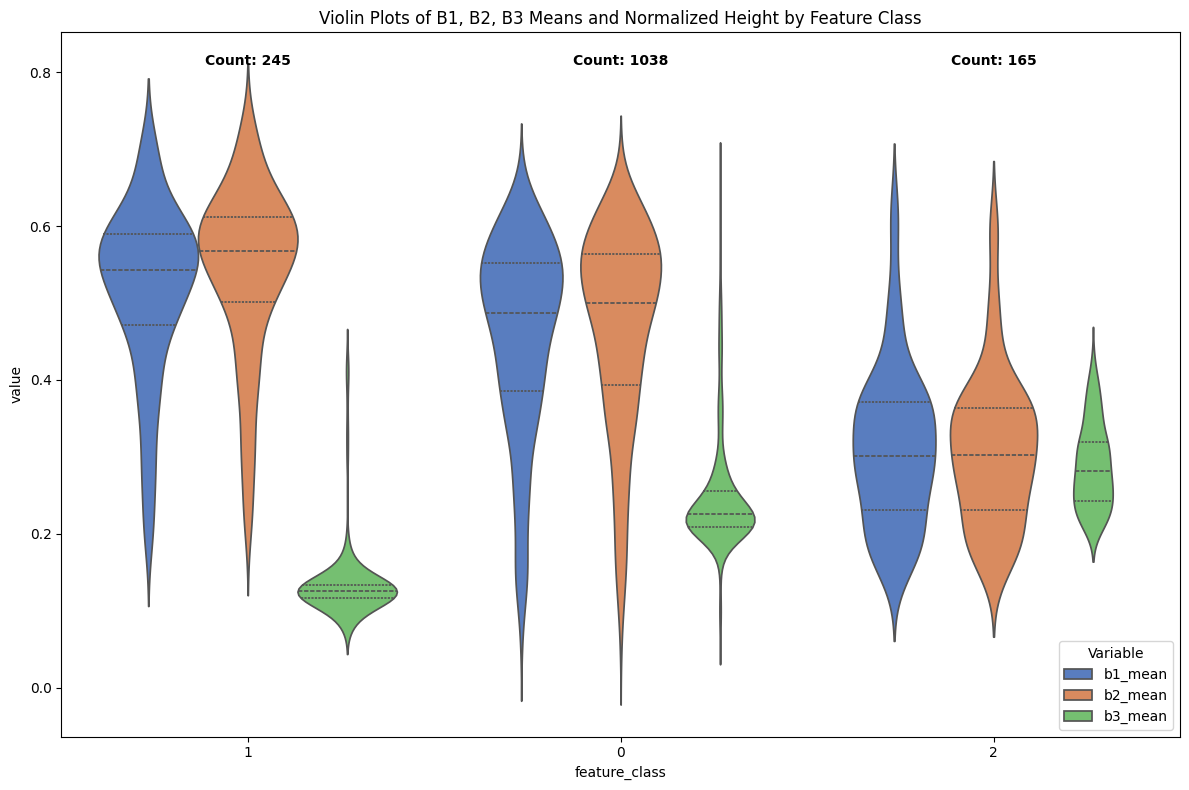

In [4]:
long_df = pd.melt(training_segments, id_vars='feature_class', value_vars=['b1_mean', 'b2_mean', 'b3_mean'],
                  var_name='variable', value_name='value')

plt.figure(figsize=(12, 8))
ax = sns.violinplot(x='feature_class', y='value', hue='variable', data=long_df, inner='quartile', palette='muted')

class_counts = training_segments['feature_class'].value_counts()
y_max = ax.get_ylim()[1] * 0.95
feature_classes = training_segments['feature_class'].unique()

for i, feature_class in enumerate(feature_classes):
    count = class_counts.get(feature_class, 0)
    ax.text(i, y_max, f'Count: {count}', horizontalalignment='center', size='medium', color='black', weight='semibold')

plt.title('Violin Plots of B1, B2, B3 Means and Normalized Height by Feature Class')
plt.tight_layout()

ax.legend(title='Variable', loc='lower right', bbox_to_anchor=(1, 0))

plt.show()

In [5]:
# i = 8
# raster_path = f"/mnt/c/tmp/trial_tiles/plt{i}.tif"
img = open_geotiff(raster_path, bands=[8,7,5])
segmented_image = ImageSegments(img, method="slic", n_segments=15000, compactness=10, max_num_iter=100, sigma=0.5, convert2lab=True, slic_zero=True)

/home/milo/miniconda3/envs/gdal_env/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(
Analyzing Segments: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████


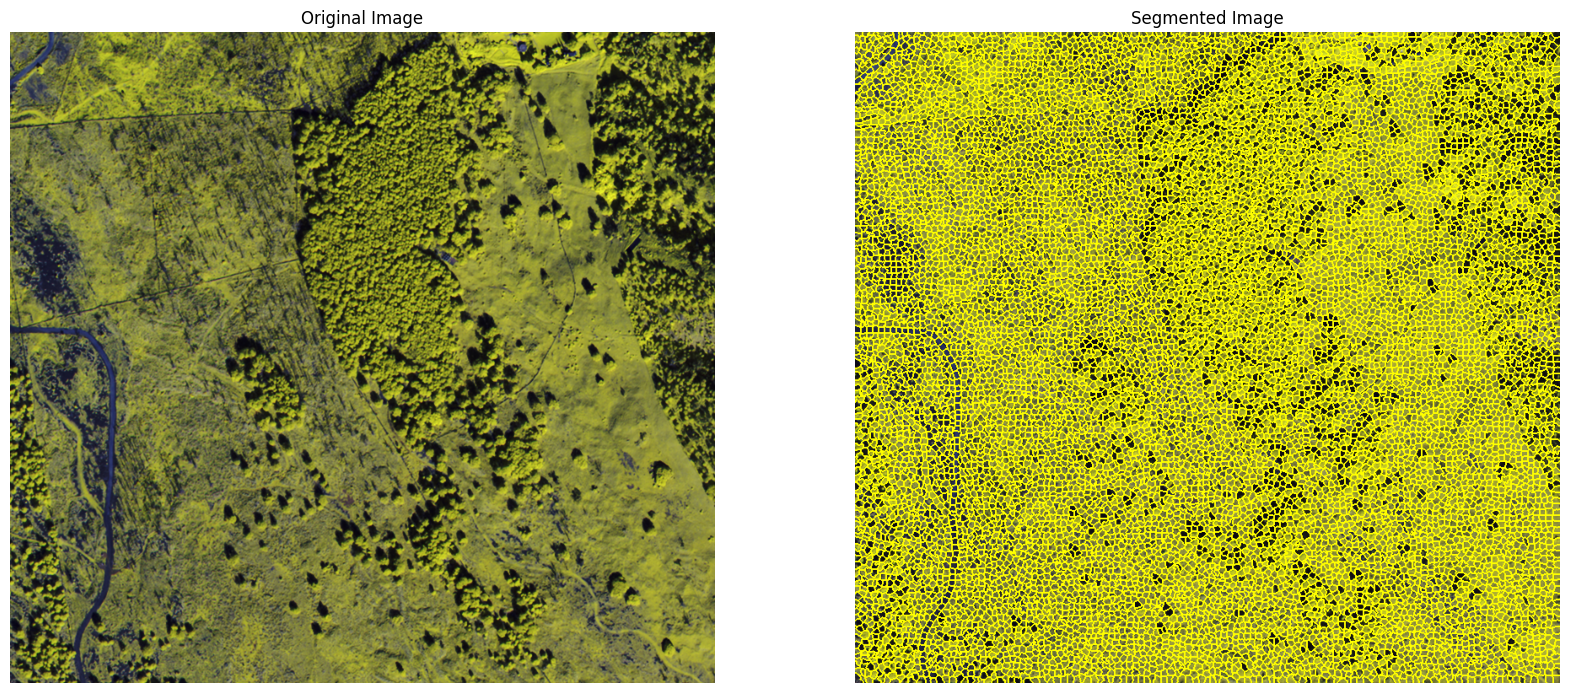

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].imshow(img.img)
axs[0].axis('off')
axs[0].set_title('Original Image') 

axs[1].imshow(segmented_image.img)
axs[1].axis('off')
axs[1].set_title('Segmented Image')

plt.show()

In [7]:
classified = classify(segmented_image, training_segments, method='rf', compute_shap=True, compute_reports=True)

/home/milo/miniconda3/envs/gdal_env/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/milo/miniconda3/envs/gdal_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/milo/miniconda3/envs/gdal_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/milo/miniconda3/envs/gdal_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetr

In [8]:
print(classified.report)

              precision    recall  f1-score   support

           0       0.73      1.00      0.85       530
           1       0.00      0.00      0.00       117
           2       0.00      0.00      0.00        77

    accuracy                           0.73       724
   macro avg       0.24      0.33      0.28       724
weighted avg       0.54      0.73      0.62       724



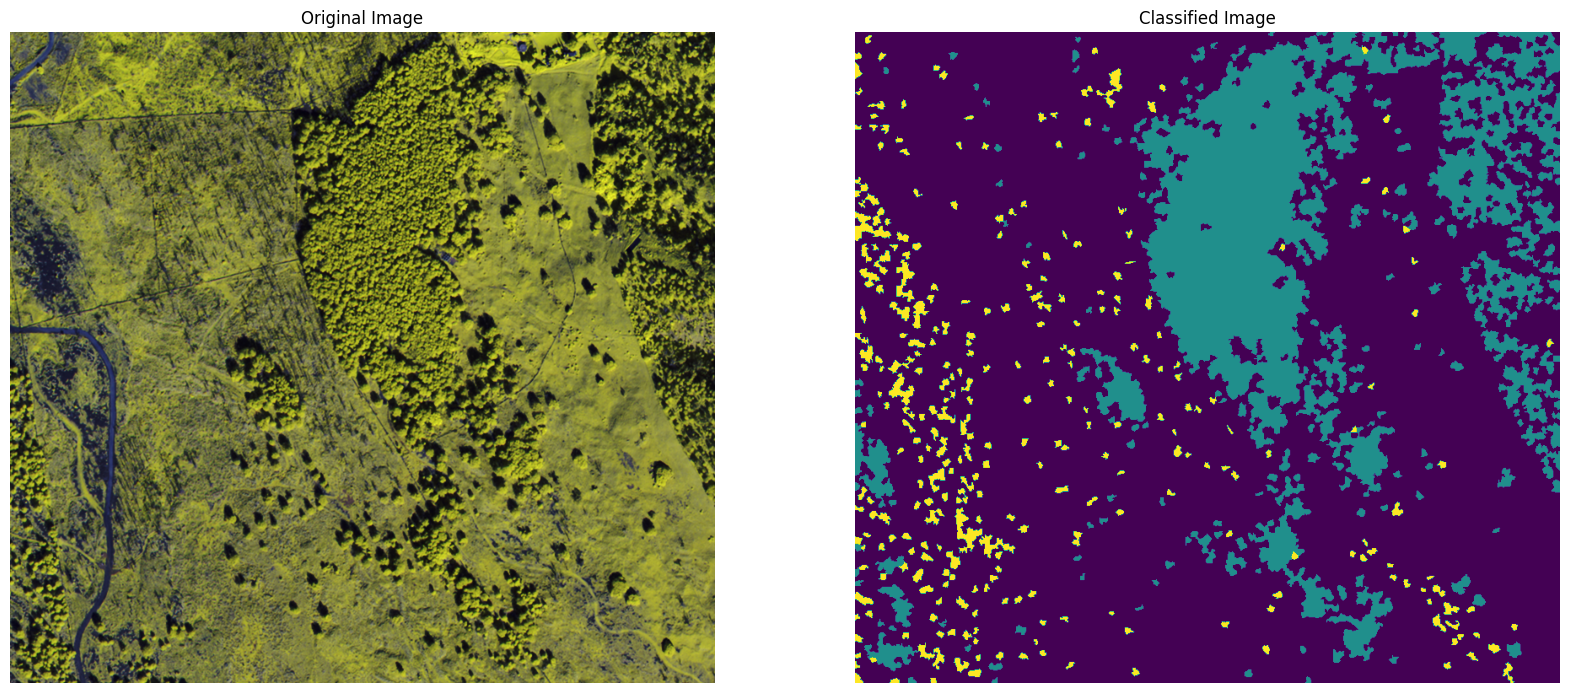

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].imshow(img.img)
axs[0].axis('off')
axs[0].set_title('Original Image')

axs[1].imshow(classified.classified_image)
axs[1].axis('off')
axs[1].set_title('Classified Image') 

plt.show()

In [12]:
import shap

print('SHAP Values shape:', classified.shap_values[0].shape)
print('Test data shape:', classified.x_test.shape)

SHAP Values shape: (19, 3)
Test data shape: (724, 19)


In [ ]:
raster_path = '/mnt/c/tmp/chm_training.tif'

stats = zonal_stats(training_segments, raster_path, stats="mean", geojson_out=True)
stats_segments = zonal_stats(segmented_image.statistics, raster_path, stats="mean", geojson_out=True)

training_segments['height'] = [stat['properties']['mean'] for stat in stats]
segmented_image.statistics['height'] = [stat['properties']['mean'] for stat in stats_segments]

In [ ]:
# classified.write_geotiff("/Users/iosefa/classified.tif")